## This script creates plots for finer scale model evaluations

This includes:
1. Process data for further analysis
2. Double-mass plot
3. Event Mean Concentration or seasonal concentration across all years.

In [44]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# common settings
lab_fontsize = 13
fig_dir = '../output/figs/'

In [46]:
# Function for convert data to 
def norm_data(df, flow_col, din_load_col):
    """
    df: dataframe containing datetime, daily flow and load.
    """
    # Sample DataFrame creation (replace this with your actual DataFrame)
    # Define water year: if the month is July (7) or later, it belongs to the next calendar year
    df['water_year'] = df['date'].apply(lambda x: x.year - 1 if x.month < 7 else x.year)
    # Normalize the data within each water year
    df['normalized_flow'] = df.groupby('water_year')[flow_col].transform(lambda x: x / x.sum())
    df['normalized_DIN_load'] = df.groupby('water_year')[din_load_col].transform(lambda x: x / x.sum())
    # Add cumulative columns
    df['cum_flow'] = df.groupby('water_year')['normalized_flow'].cumsum()
    df['cum_din_load'] = df.groupby('water_year')['normalized_DIN_load'].cumsum()
    return df

In [47]:
## Read model simulations and calculate the normalized value
dir = '../output/DailyData_run_till_2017_20241125/'
mod_fn_list = os.listdir(dir)
mod_fn_list = [fn for fn in mod_fn_list if '_' in fn ]
cum_fn = 'ModCumuFlowLoad.xlsx' # Excel file for saving cumulative normalized flow and loads.
flow_col = 'Q (m3/s)'; din_load_col = 'Load (t)'
# Calculate the cumulative normalized value for flow and load.
if not os.path.exists(dir + cum_fn):
    with pd.ExcelWriter(dir + cum_fn) as writer:
        for fn in mod_fn_list:
            flow_load = pd.read_csv(dir + fn)
            flow_load.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
            flow_load['date'] = pd.to_datetime(flow_load['date'], format='%Y-%m-%d')
            df = norm_data(flow_load, flow_col, din_load_col)
            df.to_excel(writer, sheet_name=fn.split('.')[0], index=False)

In [48]:
## Read observations and calculate the normalized value
dir_measunc = 'code for measurement uncertainty/output/resample_freq100_new_assumption/'
obs_daily_ensmb_fn = 'dailyloadunc.csv'
obs_cum_fn = 'ObsCumuFlowLoadEnsmb.xlsx' # Excel file for saving cumulative normalized flow and loads.
flow_col = 'Q (m3/s)'; din_load_col = 'Load (t)'
flow_load_all_ensmb = df.filter(['date', 'Q (m3/s)', 'Load (t)', 'water_year'])
# Calculate the cumulative normalized value for flow and load.
if not os.path.exists(dir + obs_cum_fn):
    with pd.ExcelWriter(dir + obs_cum_fn) as writer:
        obs_daily_ensmb = pd.read_csv(dir_measunc + obs_daily_ensmb_fn, header=None, index_col=0)
        for col in obs_daily_ensmb.columns:
            flow_load_all_ensmb.loc[:, 'Load (t)'] = obs_daily_ensmb[col].values
            df = norm_data(flow_load_all_ensmb, flow_col, din_load_col)
            df.to_excel(writer, sheet_name=f'RUN_{col}', index=False)

### 3-1 Double-mass plot

In [55]:
# Read cumulative of normalized data
# if use the given daily timeseries as true values
# data_dir = '../data/'
# fn_obs = 'ObsCumuFlowLoad.csv'
# df_obs = pd.read_csv(f'{data_dir}{fn_obs}');
# if using the interpolation realisations with uncertainty considered as base observations
fn_obs = 'ObsCumuFlowLoadEnsmb.xlsx'
df_obs = pd.read_excel(f'{dir}{fn_obs}', sheet_name='RUN_1');
fn_mod = 'ModCumuFlowLoad.xlsx'
df_mod = pd.read_excel(f'{dir}{fn_mod}', sheet_name='RUN_0');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


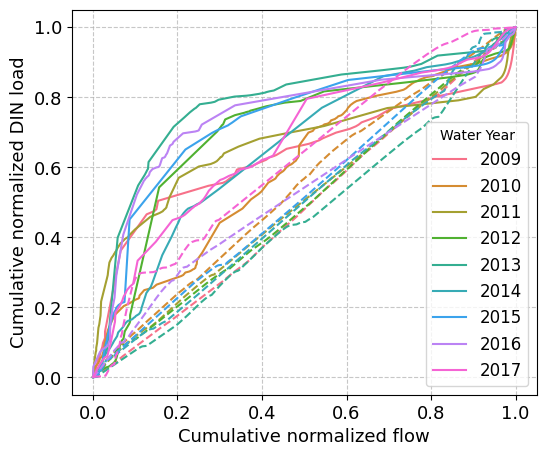

In [52]:
# Set up colors using Seaborn
unique_years = df_mod[df_mod['water_year'] <= 2017]['water_year'].unique()
palette = sns.color_palette("husl", len(unique_years))  # Using a hue-saturation-lightness palette
plt.figure(figsize=(6, 5))
for i, water_year in enumerate(unique_years):
    year_data = df_mod[df_mod['water_year'] == water_year]
    # Cumulative sum for double-mass plot
    cum_flow = year_data['cum_flow']
    cum_din_load = year_data['cum_din_load']
    obs_year_data = df_obs[df_obs['water_year'] == water_year]
    obs_cum_flow = obs_year_data['cum_flow']
    obs_cum_din_load = obs_year_data['cum_din_load']
    plt.plot(cum_flow, cum_din_load, color=palette[i], linestyle = '--')
    # Hide the legend
    plt.legend(fontsize = lab_fontsize).set_visible(False)
    plt.plot(obs_cum_flow, obs_cum_din_load, label=str(water_year), color=palette[i])

# plt.title('Double-Mass Plot for Each Water Year', fontsize = lab_fontsize)
plt.xlabel('Cumulative normalized flow', fontsize = lab_fontsize)
plt.ylabel('Cumulative normalized DIN load', fontsize = lab_fontsize)
plt.legend(title='Water Year', fontsize = 12)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines
plt.tick_params(axis= 'both', labelsize=lab_fontsize)
plt.savefig(f'{fig_dir}DoubleMassPlot.png', format = 'png', dpi=300)

### How to add uncertainty to double-mass plot?

In [53]:
# TODO: Add uncertainty to double mass plot.# Select three years: 2013-2015
# Read the ensemble of normalized values for both obs and mod
# Read all sheets into a dictionary of DataFrames
df_sheets = pd.read_excel(dir + fn_mod, sheet_name=None)
norm_data_unc = {'mod':{'2013': np.zeros(shape=(365, 100)), '2014': np.zeros(shape=(365, 100)), '2015': np.zeros(shape=(366, 100))}, 
                 'obs':{'2013': np.zeros(shape=(365, 100)), '2014': np.zeros(shape=(365, 100)), '2015': np.zeros(shape=(366, 100))}}
# Iterate over each sheet (key is the sheet name, value is the DataFrame)
kk = 0
for sheet_name, df in df_sheets.items():
    print(f"Processing sheet: {sheet_name}")
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    # Select data for given years
    for yr in range(2013, 2016):
        norm_data_unc['mod'][str(yr)][:, kk] = df[df['water_year'] == yr].loc[:, 'cum_din_load'].values
    kk += 1

# Iterate each sheet of observations
kk = 0
obd_df_sheets = pd.read_excel(dir + 'ObsCumuFlowLoadEnsmb.xlsx', sheet_name=None)
for sheet_name, df in obd_df_sheets.items():
    print(f"Processing sheet: {sheet_name}")
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    # Select data for given years
    for yr in range(2013, 2016):
        if kk < 100: # Observation uncertainty 101 realisation sets and thus drop the last set.
            norm_data_unc['obs'][str(yr)][:, kk] = df[df['water_year'] == yr].loc[:, 'cum_din_load'].values
    kk += 1

Processing sheet: RUN_0
Processing sheet: RUN_1
Processing sheet: RUN_10
Processing sheet: RUN_11
Processing sheet: RUN_12
Processing sheet: RUN_13
Processing sheet: RUN_14
Processing sheet: RUN_15
Processing sheet: RUN_16
Processing sheet: RUN_17
Processing sheet: RUN_18
Processing sheet: RUN_19
Processing sheet: RUN_2
Processing sheet: RUN_20
Processing sheet: RUN_21
Processing sheet: RUN_22
Processing sheet: RUN_23
Processing sheet: RUN_24
Processing sheet: RUN_25
Processing sheet: RUN_26
Processing sheet: RUN_27
Processing sheet: RUN_28
Processing sheet: RUN_29
Processing sheet: RUN_3
Processing sheet: RUN_30
Processing sheet: RUN_31
Processing sheet: RUN_32
Processing sheet: RUN_33
Processing sheet: RUN_34
Processing sheet: RUN_35
Processing sheet: RUN_36
Processing sheet: RUN_37
Processing sheet: RUN_38
Processing sheet: RUN_39
Processing sheet: RUN_4
Processing sheet: RUN_40
Processing sheet: RUN_41
Processing sheet: RUN_42
Processing sheet: RUN_43
Processing sheet: RUN_44
Proce

In [ ]:
# Calculate the uncertainty range (P0.025-P0.975) for each year
unctn_norm_ranges =  {'mod':{'2013': np.zeros(shape=(365, 2)), '2014': np.zeros(shape=(365, 2)), '2015': np.zeros(shape=(366, 2))}, 
                 'obs':{'2013': np.zeros(shape=(365, 2)), '2014': np.zeros(shape=(365, 2)), '2015': np.zeros(shape=(366, 2))}}
for yr in range(2013, 2016):
    unctn_norm_ranges['mod'][str(yr)][:, 0:2] = np.quantile(norm_data_unc['mod'][str(yr)], [0.025, 0.975], axis=1).T
    unctn_norm_ranges['obs'][str(yr)][:, 0:2] = np.quantile(norm_data_unc['obs'][str(yr)], [0.025, 0.975], axis=1).T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


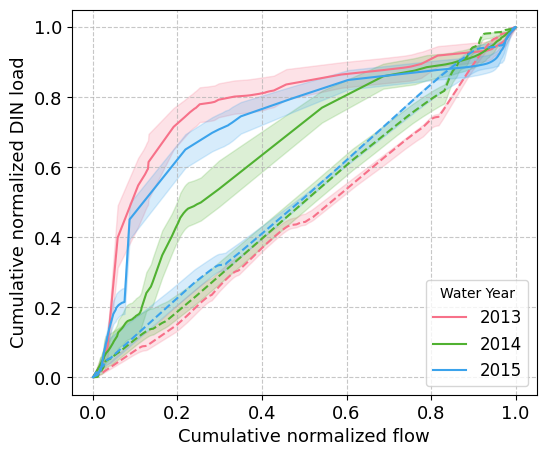

In [56]:
# Plot the double-mass plot for 2013-2015 with uncertainty ranges included
# Set up colors using Seaborn
unique_years = [2013, 2014, 2015]
palette = sns.color_palette("husl", len(unique_years))  # Using a hue-saturation-lightness palette
plt.figure(figsize=(6, 5))
for i, water_year in enumerate(unique_years):
    year_data = df_mod[df_mod['water_year'] == water_year]
    # Cumulative sum for double-mass plot
    cum_flow = year_data['cum_flow']
    cum_din_load = year_data['cum_din_load']
    obs_year_data = df_obs[df_obs['water_year'] == water_year]
    obs_cum_flow = obs_year_data['cum_flow']
    obs_cum_din_load = obs_year_data['cum_din_load']
    plt.plot(cum_flow, cum_din_load, color=palette[i], linestyle = '--')
    # Add the uncertainty band (shaded region)
    plt.fill_between(cum_flow, unctn_norm_ranges['mod'][str(water_year)][:, 0], \
                     unctn_norm_ranges['mod'][str(water_year)][:, 1], color=palette[i], \
                        alpha=0.2)
    # Hide the legend
    plt.legend(fontsize = lab_fontsize).set_visible(False)
    plt.plot(obs_cum_flow, obs_cum_din_load, label=str(water_year), color=palette[i])
    plt.fill_between(obs_cum_flow, unctn_norm_ranges['obs'][str(water_year)][:, 0], \
                     unctn_norm_ranges['obs'][str(water_year)][:, 1], color=palette[i], \
                        alpha=0.2)

# plt.title('Double-Mass Plot for Each Water Year', fontsize = lab_fontsize)
plt.xlabel('Cumulative normalized flow', fontsize = lab_fontsize)
plt.ylabel('Cumulative normalized DIN load', fontsize = lab_fontsize)
plt.legend(title='Water Year', fontsize = 12)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines
plt.tick_params(axis= 'both', labelsize=lab_fontsize)
plt.savefig(f'{fig_dir}DoubleMassPlotWithUnctn.png', format = 'png', dpi=300)

### 3-2 seasonal concentrations across years

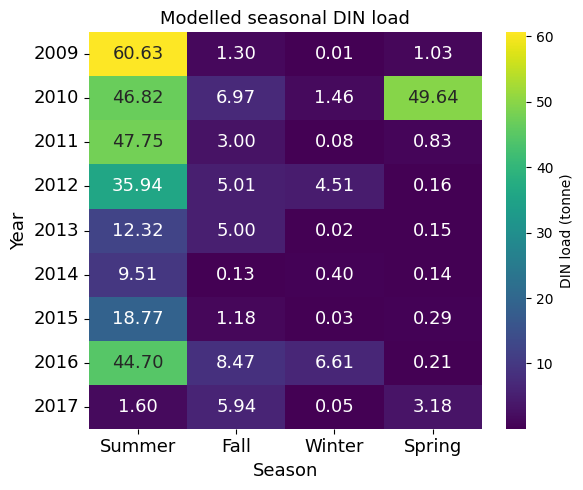

In [11]:
# Make sure 'date' is in YYYY-MM-DD format and 'DIN_concentration' holds the DIN data
# Extract year, month, and season from the date
df_mod['year'] = df_mod['date'].dt.year
df_mod['month'] = df_mod['date'].dt.month
df_mod['season'] = pd.cut(df_mod['month'], bins=[0, 3, 6, 9, 12], 
                      labels=['Summer', 'Fall', 'Winter', 'Spring'], right=True)

# Calculate total DIN load and total flow for each year and season
seasonal_totals_mod = df_mod[df_mod['date'] <= '2018-07-01'].groupby(['year', 'season']).agg(
    total_DIN_load=(din_load_col, 'sum'),
    total_flow=(flow_col, 'sum'),
    normalized_load=('normalized_DIN_load', 'sum')
).reset_index()

# Create Water year columns for plotting 
seasonal_totals_mod['water_year'] = seasonal_totals_mod['year']
for ii in range(seasonal_totals_mod.shape[0]):
    if (seasonal_totals_mod.loc[ii, 'season'] == 'Summer') | (seasonal_totals_mod.loc[ii, 'season'] == 'Fall'):
        seasonal_totals_mod.loc[ii, 'water_year'] = seasonal_totals_mod.loc[ii, 'water_year'] - 1
seasonal_totals_mod.dropna(inplace=True)

# Calculate seasonal DIN concentration
seasonal_totals_mod['DIN_concentration'] = 1e9/86400/1000*seasonal_totals_mod['total_DIN_load'] / seasonal_totals_mod['total_flow']
# Calculate mean DIN concentration for each year and season
seasonal_avg = seasonal_totals_mod.groupby(['water_year', 'season'])['DIN_concentration'].mean().unstack()
season_load_sum = seasonal_totals_mod.groupby(['water_year', 'season'])['total_DIN_load'].mean().unstack()
seasonal_avg.dropna(inplace=True)
season_load_sum.dropna(inplace=True)
# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(season_load_sum, annot=True, fmt=".2f", cmap='viridis',annot_kws={'size': lab_fontsize},\
             cbar_kws={'label': 'DIN load (tonne)'})

# Customize the plot
plt.title('Modelled seasonal DIN load', fontsize=lab_fontsize)
plt.xlabel('Season', fontsize=lab_fontsize)
plt.ylabel('Year', fontsize=lab_fontsize)
plt.xticks(fontsize=lab_fontsize)
plt.yticks(fontsize=lab_fontsize, rotation = 0)
plt.tight_layout()  # Adjust layout for better fit
plt.savefig(f'{fig_dir}ModelSeasonalLoad.png', format='png', dpi=300)

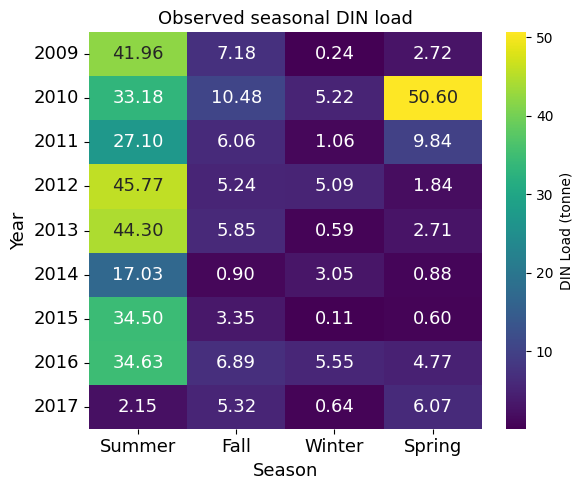

In [12]:
# Make sure 'date' is in YYYY-MM-DD format and 'DIN_concentration' holds the DIN data
# Extract year, month, and season from the date
df_obs['date'] = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
df_obs['year'] = df_obs['date'].dt.year
df_obs['month'] = df_obs['date'].dt.month
df_obs['season'] = pd.cut(df_obs['month'], bins=[0, 3, 6, 9, 12], 
                      labels=['Summer', 'Fall', 'Winter', 'Spring'], right=True)

# Calculate total DIN load and total flow for each year and season
seasonal_totals_obs = df_obs[df_obs['date'] <= '2018-07-01'].groupby(['year', 'season']).agg(
    total_DIN_load=(din_load_col, 'sum'),
    total_flow=(flow_col, 'sum'),
    normalized_load=('normalized_DIN_load', 'sum')
).reset_index()

# Create Water year columns for plotting 
seasonal_totals_obs['water_year'] = seasonal_totals_obs['year']
seasonal_totals_obs['load_diff'] = seasonal_totals_mod['total_DIN_load'] - seasonal_totals_obs['total_DIN_load']
for ii in range(seasonal_totals_obs.shape[0]):
    if (seasonal_totals_obs.loc[ii, 'season'] == 'Summer') | (seasonal_totals_obs.loc[ii, 'season'] == 'Fall'):
        seasonal_totals_obs.loc[ii, 'water_year'] = seasonal_totals_obs.loc[ii, 'water_year'] - 1
seasonal_totals_obs.dropna(inplace=True)

# Calculate seasonal DIN concentration
seasonal_totals_obs['DIN_concentration'] = 1e9/86400/1000*seasonal_totals_obs['total_DIN_load'] / seasonal_totals_obs['total_flow']
# Calculate mean DIN concentration for each year and season
seasonal_avg = seasonal_totals_obs.groupby(['water_year', 'season'])['DIN_concentration'].mean().unstack()
season_load_sum = seasonal_totals_obs.groupby(['water_year', 'season'])['total_DIN_load'].mean().unstack()
season_load_diff = seasonal_totals_obs.groupby(['water_year', 'season'])['load_diff'].mean().unstack()
seasonal_avg.dropna(inplace=True)
season_load_sum.dropna(inplace=True)
season_load_diff.dropna(inplace=True)
# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(season_load_sum, annot=True, fmt=".2f", cmap='viridis',annot_kws={'size': lab_fontsize},\
             cbar_kws={'label': 'DIN Load (tonne)'})

# Customize the plot
plt.title('Observed seasonal DIN load', fontsize=lab_fontsize)
plt.xlabel('Season', fontsize=lab_fontsize)
plt.ylabel('Year', fontsize=lab_fontsize)
plt.xticks(fontsize=lab_fontsize)
plt.yticks(fontsize=lab_fontsize, rotation = 0)
plt.tight_layout()  # Adjust layout for better fit
plt.savefig(f'{fig_dir}ObserveSeasonalLoad.png', format='png', dpi=300)

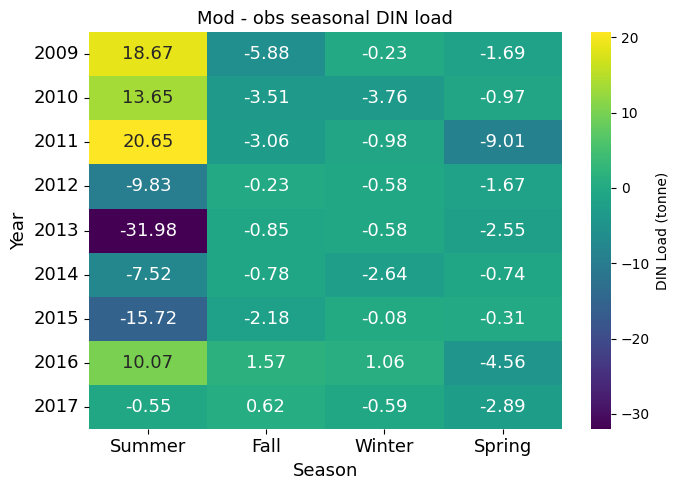

In [14]:
# Create plot showing the difference in seasonal loads
# Create the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(season_load_diff, annot=True, fmt=".2f", cmap='viridis',annot_kws={'size': lab_fontsize},\
             cbar_kws={'label': 'DIN Load (tonne)'})
# Customize the plot
plt.title('Mod - obs seasonal DIN load', fontsize=lab_fontsize)
plt.xlabel('Season', fontsize=lab_fontsize)
plt.ylabel('Year', fontsize=lab_fontsize)
plt.xticks(fontsize=lab_fontsize)
plt.yticks(fontsize=lab_fontsize, rotation = 0)
plt.tight_layout()  # Adjust layout for better fit
plt.savefig(f'{fig_dir}DiffSeasonalLoad.png', format='png', dpi=300)

## Plot time series and add events to it

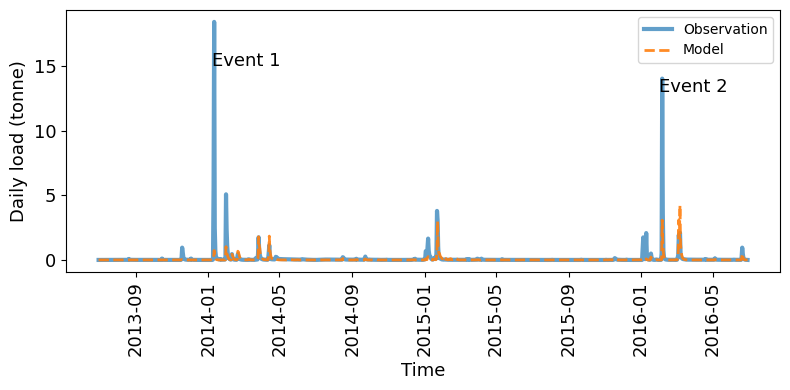

In [16]:
# Define start and end time of selected events
event_start = pd.to_datetime(['09/01/2014', '01/02/2016'], dayfirst=True)
event_end = pd.to_datetime(['26/01/2014', '14/02/2016'], dayfirst=True)
# Add time series for 2012-2016 with df_obs and df_mod
fig = plt.figure(figsize=(8, 4))
sns.lineplot(df_obs[(df_obs['date'] >= '2013-06-30') & (df_obs['date'] < '2016-06-30')], \
             x='date', y='Load (t)', alpha = 0.7, label = 'Observation', linewidth=3)
sns.lineplot(df_mod[(df_mod['date'] >= '2013-06-30') & (df_mod['date'] < '2016-06-30')], \
             x='date', y='Load (t)', alpha = 0.9, label = 'Model', linestyle = '--', linewidth=2)
plt.xticks(rotation=90)
plt.legend()
plt.tick_params(axis = 'both', labelsize = lab_fontsize)
plt.ylabel('Daily load (tonne)', fontsize = lab_fontsize)
plt.xlabel('Time', fontsize = lab_fontsize)
#TODO Add arrows and text
# Add an arrow pointing to a specific point
plt.text(pd.to_datetime('08/01/2014', dayfirst=True), 15, 'Event 1', fontsize = lab_fontsize)
plt.text(pd.to_datetime('31/01/2016', dayfirst=True), 13, 'Event 2', fontsize = lab_fontsize)
plt.tight_layout()
plt.savefig(f'{fig_dir}DailyLoadTimeSeries.png', format='png', dpi = 300)

In [17]:
## Plot process for three selected events
# File name of mod and obs files
obs_flow_load_fn = 'C:/Users/u1066632/OneDrive - Australian National University/WORKANU/Projects/GraphEvalUnc/data/obs_low_interp_flow.csv'
obs_conc_fn = 'C:/Users/u1066632/OneDrive - Australian National University/WORKANU/Projects/GraphEvalUnc/data/126001A_din_concentrations_conditions.csv'
mod_flow_load_fn = 'C:/Users/u1066632/OneDrive - Australian National University/WORKANU/Projects/GraphEvalUnc/output/DailyData_run_till_2017_20241125/RunDefaultPar.csv'
obs_ql = pd.read_csv(obs_flow_load_fn)
obs_conc = pd.read_csv(obs_conc_fn) 
mod_ql = pd.read_csv(mod_flow_load_fn)
mod_ql.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
# Convert date column to datetime
obs_ql['date'] = pd.to_datetime(obs_ql['date'], dayfirst=True)
obs_conc['DateTime'] = pd.to_datetime(obs_conc['DateTime'], dayfirst=True)
mod_ql['Date'] = pd.to_datetime(mod_ql['Date'], yearfirst=True)
# Calculate the modelled concentration as load/flow
mod_ql['Conc (mg/L)'] = mod_ql['Load (t)'] * 1e9/ (mod_ql['Q (m3/s)'] * 86400 *1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\u1066632\AppData\Local\Temp\ipykernel_2004\4132282892.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2, ii].set_xticklabels([dt.strftime('%d/%m/%Y') for dt in event_tm[ii][0::2]], rotation = 90)


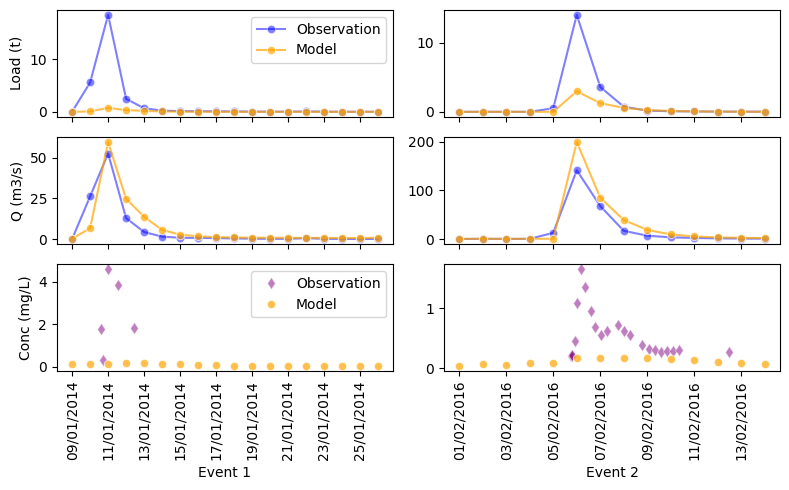

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 5))
n_col = 0
event_tm = []
for start_tm, end_tm in zip(event_start, event_end):
    # Plot daily load
    event_tm.append(obs_ql[(obs_ql['date'] <= end_tm) & (obs_ql['date'] >= start_tm)].date)
    sns.lineplot(data = obs_ql[(obs_ql['date'] <= end_tm) & (obs_ql['date'] >= start_tm)], \
                 x='date', y='Load (t)', ax=axes[0, n_col], color='blue', alpha = 0.5, marker='o', label='Observation')
    sns.lineplot(data = mod_ql[(mod_ql['Date'] <= end_tm) & (mod_ql['Date'] >= start_tm)], \
                 x='Date', y='Load (t)', ax=axes[0, n_col], color='orange', alpha = 0.7, marker='o', label='Model')
    # Plot daily flow
    sns.lineplot(data = obs_ql[(obs_ql['date'] <= end_tm) & (obs_ql['date'] >= start_tm)], \
                 x='date', y='Q (m3/s)', ax=axes[1, n_col], color='blue', alpha = 0.5, marker='o')
    sns.lineplot(data = mod_ql[(mod_ql['Date'] <= end_tm) & (mod_ql['Date'] >= start_tm)], \
                 x='Date', y='Q (m3/s)', ax=axes[1, n_col], color='orange', alpha = 0.7, marker='o')
    # Plot daily concentration
    sns.lineplot(data = obs_conc[(obs_conc['DateTime'] <= end_tm) & (obs_conc['DateTime'] >= start_tm)], \
                 x='DateTime', y='DIN', ax=axes[2, n_col], color='purple', alpha = 0.5, marker='d', linestyle = '', label='Observation')
    sns.lineplot(data = mod_ql[(mod_ql['Date'] <= end_tm) & (mod_ql['Date'] >= start_tm)], \
                 x='Date', y='Conc (mg/L)', ax=axes[2, n_col], color='orange', alpha = 0.7, marker='o', linestyle = '', label='Model')
    n_col += 1
# set axes formats
for ii in range(2):  
    for jj in range(2):  
        axes[ii, jj].set_xticklabels([]) 
        axes[ii, jj].set_xlabel('') 
# The second column does not have yaxis label and legend. 
for ii in range(3): 
    axes[ii, 1].set_ylabel('')   
    axes[ii, 1].legend().set_visible(False)
# Set the xaxis ticks for the last row
for ii in range(2):
    axes[2, ii].set_xticklabels([dt.strftime('%d/%m/%Y') for dt in event_tm[ii][0::2]], rotation = 90)
    axes[2, ii].set_xlabel(f'Event {ii + 1}') 

# Set the axis label
axes[2, 0].set_ylabel('Conc (mg/L)')  
# Adjust the space between rows
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig(f'{fig_dir}SelectedEventProcess.png', format='png', dpi=300)